# DCGAN TUTORIAL

**Author:** Nathan Inkawhich

## Introduction
This tutorial will give an introduction to DCGANs through an example. We will train a generative adversarial network (GAN) to generate new celebrities after showing it pictures of many real celebrities. Most of the code here is from the dcgan implementation in [pytorch/examples](https://github.com/pytorch/examples), and this document will give a thorough explanation of the implementation and shed light on how and why this model works. But don’t worry, no prior knowledge of GANs is required, but it may require a first-timer to spend some time reasoning about what is actually happening under the hood. Also, for the sake of time it will help to have a GPU, or two. Lets start from the beginning.

## Generative Adversarial Networks
### What is a GAN?

GANs are a framework for teaching a DL model to capture the training data’s distribution so we can generate new data from that same distribution. GANs were invented by Ian Goodfellow in 2014 and first described in the paper [Generative Adversarial Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf). They are made of two distinct models, a generator and a discriminator. The job of the generator is to spawn ‘fake’ images that look like the training images. The job of the discriminator is to look at an image and output whether or not it is a real training image or a fake image from the generator. During training, the generator is constantly trying to outsmart the discriminator by generating better and better fakes, while the discriminator is working to become a better detective and correctly classify the real and fake images. The equilibrium of this game is when the generator is generating perfect fakes that look as if they came directly from the training data, and the discriminator is left to always guess at 50% confidence that the generator output is real or fake.

Now, lets define some notation to be used throughout tutorial starting with the discriminator. Let $x$ be data representing an image. $D(x)$ is the discriminator network which outputs the (scalar) probability that $x$ came from training data rather than the generator. Here, since we are dealing with images the input to $D(x)$ is an image of CHW size $3x64x64$. Intuitively, $D(x)$ should be HIGH when $x$ comes from training data and LOW when $x$ comes from the generator. $D(x)$ can also be thought of as a traditional binary classifier.

For the generator’s notation, let $z$ be a latent space vector sampled from a standard normal distribution. $G(z)$ represents the generator function which maps the latent vector $z$ to data-space. The goal of $G$ is to estimate the distribution that the training data comes from ($p_{data}$) so it can generate fake samples from that estimated distribution ($p_{g}$).

So, $D(G(z))$ is the probability (scalar) that the output of the generator $G$ is a real image. As described in [Goodfellow’s paper](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf), $D$ and $G$ play a minimax game in which $D$ tries to maximize the probability it correctly classifies reals and fakes ($logD(x)$), and $G$ tries to minimize the probability that $D$ will predict its outputs are fake ($log(1−D(G(x)))$). From the paper, the GAN loss function is

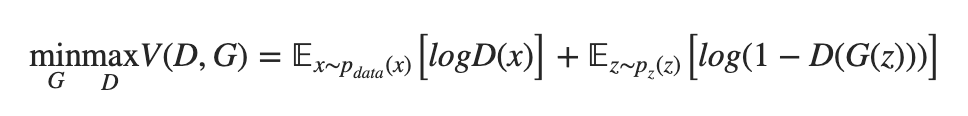

In theory, the solution to this minimax game is where $p_{g}=p_{data}$, and the discriminator guesses randomly if the inputs are real or fake. However, the convergence theory of GANs is still being actively researched and in reality models do not always train to this point.

### What is a DCGAN?

A DCGAN is a direct extension of the GAN described above, except that it explicitly uses convolutional and convolutional-transpose layers in the discriminator and generator, respectively. It was first described by Radford et. al. in the paper [Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf). The discriminator is made up of strided [convolution](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d) layers, [batch norm](https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d) layers, and [LeakyReLU](https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU) activations. The input is a 3x64x64 input image and the output is a scalar probability that the input is from the real data distribution. The generator is comprised of [convolutional-transpose](https://pytorch.org/docs/stable/nn.html#torch.nn.ConvTranspose2d) layers, batch norm layers, and [ReLU](https://pytorch.org/docs/stable/nn.html#relu) activations. The input is a latent vector, z, that is drawn from a standard normal distribution and the output is a 3x64x64 RGB image. The strided conv-transpose layers allow the latent vector to be transformed into a volume with the same shape as an image. In the paper, the authors also give some tips about how to setup the optimizers, how to calculate the loss functions, and how to initialize the model weights, all of which will be explained in the coming sections.


In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


## Inputs

Let’s define some inputs for the run:

* **dataroot** - the path to the root of the dataset folder. We will talk more about the dataset in the next section
* **workers** - the number of worker threads for loading the data with the DataLoader
* **batch_size** - the batch size used in training. The DCGAN paper uses a batch size of 128
* **image_size** - the spatial size of the images used for training. This implementation defaults to 64x64. If another size is desired, the structures of D and G must be changed. See [here](https://github.com/pytorch/examples/issues/70) for more details
* **nc** - number of color channels in the input images. For color images this is 3
* **nz** - length of latent vector
* **ngf** - relates to the depth of feature maps carried through the generator
* **ndf** - sets the depth of feature maps propagated through the discriminator
* **num_epochs** - number of training epochs to run. Training for longer will probably lead to better results but will also take much longer
* **lr** - learning rate for training. As described in the DCGAN paper, this number should be 0.0002
* **beta1** - beta1 hyperparameter for Adam optimizers. As described in paper, this number should be 0.5
* **ngpu** - number of GPUs available. If this is 0, code will run in CPU mode. If this number is greater than 0 it will run on that number of GPUs

In [2]:
# Root directory for dataset
dataroot = "data/celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

## Data

In this tutorial we will use the [Celeb-A Faces dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) which can be downloaded at the linked site, or in [Google Drive](https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg). The dataset will download as a file named *img_align_celeba.zip*. Once downloaded, create a directory named *celeba* and extract the zip file into that directory. Then, set the *dataroot* input for this notebook to the *celeba* directory you just created. The resulting directory structure should be:
```
/path/to/celeba
    -> img_align_celeba
        -> 188242.jpg
        -> 173822.jpg
        -> 284702.jpg
        -> 537394.jpg
           ...
```
This is an important step because we will be using the ImageFolder dataset class, which requires there to be subdirectories in the dataset’s root folder. Now, we can create the dataset, create the dataloader, set the device to run on, and finally visualize some of the training data.

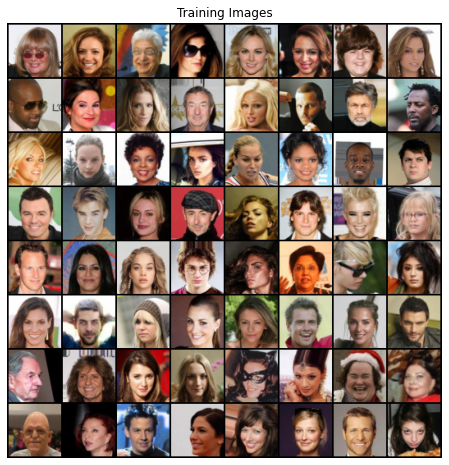

In [6]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))